<a href="https://colab.research.google.com/github/Faouzijedidi1/ResearchForex/blob/master/NN_for_Forex_V0_1_using_Keras_to_predict_patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import matplotlib
import numpy as np
import pandas as pd
import itertools
import sklearn
import keras
import time
import shap


from keras.models import Sequential
import keras.layers
from matplotlib import pyplot as plt
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mplfinance.original_flavor import candlestick_ohlc


print('Numpy version: ' + np.__version__)
print('Pandas version: ' + pd.__version__)
print('Matplotlib version: ' + matplotlib.__version__)
print('Sklearn version: ' + sklearn.__version__)
print('Keras version: ' + keras.__version__)

Numpy version: 1.18.5
Pandas version: 1.0.5
Matplotlib version: 3.2.2
Sklearn version: 0.22.2.post1
Keras version: 2.3.1


In [6]:
class MeasureTime:
    def __init__(self):
        self.start = time.time()
    def kill(self):
        print ('Time elapsed: ' + time.strftime("%H:%M:%S", time.gmtime(time.time()-self.start)))
        del self

In [9]:
my_dataset = pd.read_csv('EURUSD_Candlestick_1_Hour_2014-2020.csv')
my_dataset.tail()

,Local time,Open,High,Low,Close,Volume
41083,24.07.2020 20:00:00.000 GMT+0400,1.16343,1.16377,1.16287,1.16349,22046.7496
41084,24.07.2020 21:00:00.000 GMT+0400,1.16348,1.16445,1.16344,1.16406,7895.3100
41085,24.07.2020 22:00:00.000 GMT+0400,1.16406,1.16475,1.16361,1.16361,10610.1401
41086,24.07.2020 23:00:00.000 GMT+0400,1.16360,1.16422,1.16342,1.16411,7011.3300
41087,25.07.2020 00:00:00.000 GMT+0400,1.16411,1.16580,1.16407,1.16546,3845.4886


In [10]:
del my_dataset['Local time']
del my_dataset['Volume']

In [11]:
def graph_data_ohlc(dataset):
    fig = plt.figure()
    ax1 = plt.subplot2grid((1,1), (0,0))
    closep=dataset[:,[3]]
    highp=dataset[:,[1]]
    lowp=dataset[:,[2]]
    openp=dataset[:,[0]]
    date=range(len(closep))

    x = 0
    y = len(date)
    ohlc = []
    while x < y:
        append_me = date[x], openp[x], highp[x], lowp[x], closep[x]
        ohlc.append(append_me)
        x+=1
    candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f')
    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax1.grid(True)
    plt.xlabel('Candle')
    plt.ylabel('Price')
    plt.title('Candlestick sample representation')

    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
    plt.show()

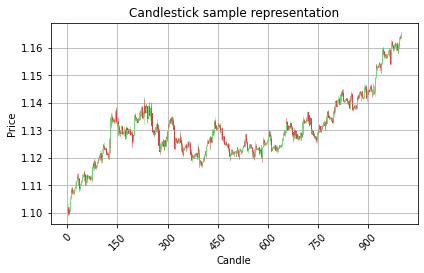

In [12]:
graph_data_ohlc(my_dataset.tail(1000).values)

In [13]:
def my_generator(data,lookback):
    final_output = []
    counter = 0
    first_row = 0
    arr = np.empty((1,lookback,4), int)
    for a in range(len(data)-lookback):
        temp_list = []
        for candle in data[first_row:first_row+lookback]:
            temp_list.append(candle)
        temp_list2 = np.asarray(temp_list)
        templist3 = [temp_list2]
        templist4 = np.asarray(templist3)
        arr = np.append(arr, templist4, axis=0)
        first_row=first_row+1
    return arr

In [14]:
cell_timer = MeasureTime()
three_dim_sequence = np.asarray(my_generator(my_dataset.values[1:],3))
cell_timer.kill()

Time elapsed: 00:00:26
